# Partially Coherent Imager (Forward Model)

This Jupyter Notebook is an interface to the partially coherent imager suitable for single and multiple scattering imaging in 3D microscopy. Multiple different setups can be simulated. The refractive index (RI) distribution in 3D can conveniently be provided by a 3D numpy array and e.g. side-loaded from external sources. 

For larger volumes in combination with the multiple scattering, we recommend to use GPU-computation as it requiers lots of computational resources. 

In [12]:
'''Hanel all imports and handle "nice/bigger" figures'''
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from datetime import datetime
import os

# load own functions
import src.simulations as experiments 
import src.model as mus
import src.tf_generate_object as tf_go
import src.data as data
import src.MyParameter as paras

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(9, 6))
mpl.rc('image', cmap='gray')
#plt.switch_backend('agg')
        
# This is depending on your setup - we have one GPU 
os.environ["CUDA_VISIBLE_DEVICES"]='0'    
os.environ["TF_CUDNN_USE_AUTOTUNE"]="0" 

# Declare some settings and variables

In [13]:
'''Define some stuff related to infrastructure'''
savepath = os.path.join('./SIMULATIONS/')#, mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

''' Define parameters '''
is_padding = False # better don't do it, some normalization is probably incorrect
is_display = True
is_optimization = False 
is_optimization_psf = False
is_flip = False
is_measurement = False

'''Choose between Born (BORN) or BPM (BPM)'''
psf_modell =  'BORN' # 1st Born
#psf_modell = 'BPM' # multiple scattering

'''Choose what kind of microsocpe you have'''
is_mictype='BF' # BF, DF, DIC, PC

'''Reset an (optional) open computational graph from Tensorflow'''
tf.reset_default_graph()

Folder exists already


# Setup system variables

In [14]:
'''Generate the Parameter class. 
It has a set of read-to-go settings for a plausible microscope setup. One can change the values according to the
own hardware configuration.'''
myparams = paras.MyParameter()

# change certain values:
myparams.Nx = myparams.Ny = 50 # Make it more coherent
myparams.Nz = 100
myparams.NAc = .2
myparams.mysize = np.array((myparams.Nz, myparams.Nx, myparams.Ny))

# print all parameters
myparams.print()


Lambda0: 0.65
nEmbb: 1.33
NAc: 0.2
NAci: 0
NAo: 0.95
shiftIcX: 0
shiftIcY: 0
dx: 0.2228
dy: 0.2228
dz: 0.7
Nx: 50
Ny: 50
Nz: 100
mysize: [100  50  50]
zernikefactors: [0 0 0 0 0 0 0 0 0 0 0]
zernikemask: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Initialize the 'virtual' microscope system 

In [15]:
''' Create the Model'''
muscat = mus.MuScatModel(myparams, is_optimization=False)

# Optional: Setup the zernike-factors using some numbers
muscat.zernikefactors = myparams.zernikefactors
muscat.zernikemask = myparams.zernikemask


Assigned some value for dn which is not good!


# Setup an artificially 3D sample

In [16]:
''' Create a 3D Refractive Index Distributaton as a artificial sample'''
mydiameter = 5
objtype = 'sphere';
obj_real= tf_go.generateObject(mysize=myparams.mysize, obj_dim=1, obj_type ='sphere', diameter = mydiameter, dn = experiments.dn, nEmbb = myparams.nEmbb)#)dn)
obj_absorption = tf_go.generateObject(mysize=myparams.mysize, obj_dim=1, obj_type ='sphere', diameter = mydiameter, dn = .0, nEmbb = 0.0)
obj = (obj_real + obj_absorption)

# Start the Tensorflow session and  create the Forward Model

In [17]:
print('Start the TF-session')
sess = tf.Session()#config=tf.ConfigProto(log_device_placement=True))

''' Compute the systems model'''
if psf_modell == 'BPM':
    # Define 'BPM' model    
    tf_fwd = muscat.compute_bpm(obj,is_padding=is_padding, mysubsamplingIC=experiments.mysubsamplingIC)    
    
elif psf_modell == 'BORN':
    # Define Born Model 
    tf_fwd = muscat.compute_born(obj, is_padding=is_padding, mysubsamplingIC=experiments.mysubsamplingIC, is_precompute_psf=True)


Start the TF-session
----------> Be aware: We are taking aberrations into account!
We are taking the gaussian illuminatino shape!
Number of Illumination Angles / Plane waves: 37
Buildup Q-PHASE Model 
We are now precomputing the ASF
Computing the fwd model in born approximation
ATTENTION: WEIRD MAGIC NUMBER for background field!!


# Compute the result on GPU

In [18]:
''' Evaluate the model '''
print('Initiliaze Variables')
sess.run(tf.global_variables_initializer())    

# The first call is -unfortunately- very expensive... 
print('Compute Result')  
start = time.time()
myfwd = sess.run(tf_fwd)
end = time.time()
print('Done. It took me: '+str(end - start)+' seconds!')

Initiliaze Variables
Compute Result
Done. It took me: 0.46576476097106934 seconds!


# Display the ASF and ATF (in case of BORN)

This is the ASF


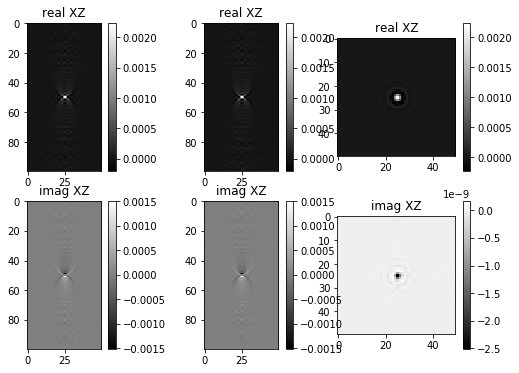

This is the ATF


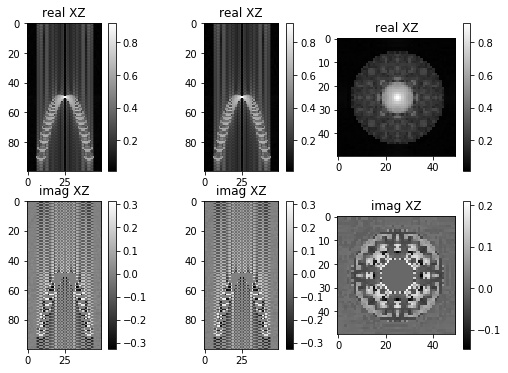

In [19]:
#%% display the results
centerslice = myfwd.shape[0]//2

if(psf_modell is 'BORN'):
    print('This is the ASF')
    plt.figure()
    plt.subplot(231), plt.title('real XZ'), plt.imshow(np.real(((muscat.myASF)))[:,muscat.myASF.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(233), plt.title('real XZ'), plt.imshow(np.real(((muscat.myASF)))[centerslice,:,:]), plt.colorbar()#, plt.show()    
    plt.subplot(232), plt.title('real XZ'), plt.imshow(np.real(((muscat.myASF)))[:,:,muscat.myASF.shape[2]//2]), plt.colorbar()#
    plt.subplot(234), plt.title('imag XZ'), plt.imshow(np.imag(((muscat.myASF)))[:,muscat.myASF.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(236), plt.title('imag XZ'), plt.imshow(np.imag(((muscat.myASF)))[centerslice,:,:]), plt.colorbar()#, plt.show()    
    plt.subplot(235), plt.title('imag XZ'), plt.imshow(np.imag(((muscat.myASF)))[:,:,muscat.myASF.shape[2]//2]), plt.colorbar(), plt.show()    
    
    print('This is the ATF')
    plt.figure()
    plt.subplot(231), plt.title('real XZ'), plt.imshow(np.real(((muscat.myATF))**.2)[:,muscat.myASF.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(233), plt.title('real XZ'), plt.imshow(np.real(((muscat.myATF))**.2)[centerslice,:,:]), plt.colorbar()#, plt.show()    
    plt.subplot(232), plt.title('real XZ'), plt.imshow(np.real(((muscat.myATF))**.2)[:,:,muscat.myASF.shape[2]//2]), plt.colorbar()#
    plt.subplot(234), plt.title('imag XZ'), plt.imshow(np.imag(((muscat.myATF))**.2)[:,muscat.myASF.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(236), plt.title('imag XZ'), plt.imshow(np.imag(((muscat.myATF))**.2)[centerslice,:,:]), plt.colorbar()#, plt.show()    
    plt.subplot(235), plt.title('imag XZ'), plt.imshow(np.imag(((muscat.myATF))**.2)[:,:,muscat.myASF.shape[2]//2]), plt.colorbar(), plt.show()    



# Display the system's apertures

(<matplotlib.axes._subplots.AxesSubplot at 0x1c3081ae80>,
 Text(0.5, 1.0, 'Angle Po'),
 <matplotlib.colorbar.Colorbar at 0x1c2f6942e8>)

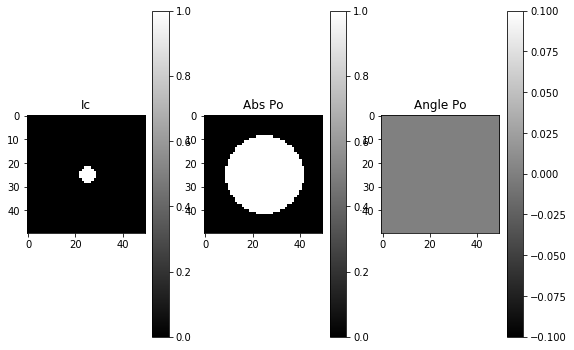

In [20]:
# Display Apertures
plt.subplot(131), plt.title('Ic'),plt.imshow(muscat.Ic), plt.colorbar()#, plt.show()
plt.subplot(132), plt.title('Abs Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.Po))), plt.colorbar()#, plt.show()
plt.subplot(133), plt.title('Angle Po'),plt.imshow(np.fft.fftshift(np.angle(muscat.Po))), plt.colorbar()# plt.show()

# Display result of FWD model

This is the result of the FWD-model (real/imag)


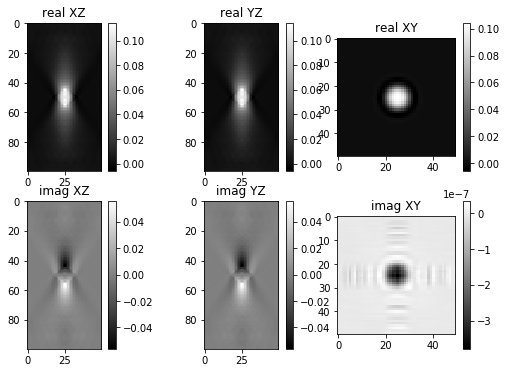

This is the result of the FWD-model (abs/angle)


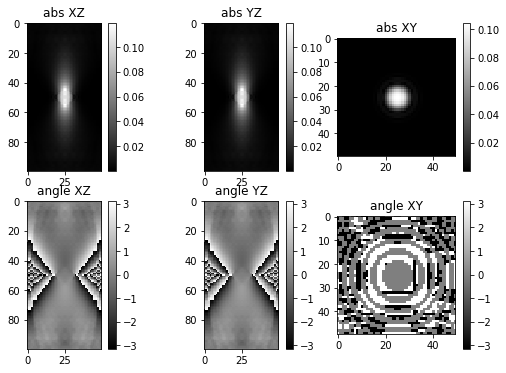

(<matplotlib.axes._subplots.AxesSubplot at 0x1c30368278>,
 Text(0.5, 1.0, 'angle XY'),
 None)

In [23]:
#%%
print('This is the result of the FWD-model (real/imag)')
plt.figure()    
plt.subplot(231), plt.title('real XZ'),plt.imshow(np.real(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
plt.subplot(232), plt.title('real YZ'),plt.imshow(np.real(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
plt.subplot(233), plt.title('real XY'),plt.imshow(np.real(myfwd)[centerslice,:,:]), plt.colorbar()# plt.show()
plt.subplot(234), plt.title('imag XZ'),plt.imshow(np.imag(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
plt.subplot(235), plt.title('imag YZ'),plt.imshow(np.imag(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
plt.subplot(236), plt.title('imag XY'),plt.imshow(np.imag(myfwd)[centerslice,:,:]), plt.colorbar(), plt.show()

print('This is the result of the FWD-model (abs/angle)')
plt.figure()
plt.subplot(231), plt.title('abs XZ'),plt.imshow(np.abs(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
plt.subplot(232), plt.title('abs YZ'),plt.imshow(np.abs(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
plt.subplot(233), plt.title('abs XY'),plt.imshow(np.abs(myfwd)[centerslice,:,:]), plt.colorbar()# plt.show()
plt.subplot(234), plt.title('angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
plt.subplot(235), plt.title('angle YZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
plt.subplot(236), plt.title('angle XY'),plt.imshow(np.angle(myfwd)[centerslice,:,:]), plt.colorbar(), plt.show()

# Show the 3D RI distribution

This is the result of the FWD-model (real/imag)


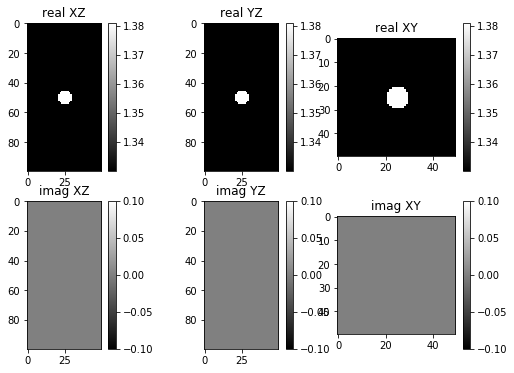

(<matplotlib.axes._subplots.AxesSubplot at 0x1c2efd1390>,
 Text(0.5, 1.0, 'imag XY'),
 None)

In [25]:
#%%
print('This is the result of the FWD-model (real/imag)')
plt.figure()    
plt.subplot(231), plt.title('real XZ'),plt.imshow(np.real(obj)[:,obj.shape[1]//2,:]), plt.colorbar()#, plt.show()
plt.subplot(232), plt.title('real YZ'),plt.imshow(np.real(obj)[:,:,obj.shape[2]//2]), plt.colorbar()#, plt.show()
plt.subplot(233), plt.title('real XY'),plt.imshow(np.real(obj)[centerslice,:,:]), plt.colorbar()# plt.show()
plt.subplot(234), plt.title('imag XZ'),plt.imshow(np.imag(obj)[:,obj.shape[1]//2,:]), plt.colorbar()#, plt.show()
plt.subplot(235), plt.title('imag YZ'),plt.imshow(np.imag(obj)[:,:,obj.shape[2]//2]), plt.colorbar()#, plt.show()
plt.subplot(236), plt.title('imag XY'),plt.imshow(np.imag(obj)[centerslice,:,:]), plt.colorbar(), plt.show()


# Save the result

In [22]:
#%% save the resultsl
np.save(savepath+'allAmp_simu.npy', myfwd)
data.export_realdatastack_h5(savepath+'/obj.h5', 'phase, abs', 
                        np.stack((np.real(obj),np.imag(obj)), axis=0))
data.export_realdatastack_h5(savepath+'/myfwd.h5', 'real, imag', 
                        np.stack((np.real(myfwd),
                                  np.imag(myfwd)), axis=0))

Assuming first axis is time
Assuming first axis is time
